In [2]:
import os
import re
from collections import Counter
from itertools import combinations
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import nltk
import seaborn as sns
from fa2 import ForceAtlas2
from nltk.util import ngrams
from scipy.stats import norm

In [3]:
### load the dataset
os.chdir('./ddps')
data=pd.read_pickle('data_transformed_cleaned.pkl')
# normalize the datetime 
data['timestamp_converted']=pd.to_datetime(data.timestamp_converted, errors='coerce')

In [4]:
# use activity type and platform as lexicon
data["activity_type"]=data["platform"]+"_"+ data["activity_type"]
platform_dict=dict(data[["activity_type", "platform"]].values)

In [5]:
# use bigram to build directed network based on sequence pairs of activities in their original order 
def get_ngrams(data, n):
    sequences = data.groupby('user_id')['activity_type'].apply(list)
    ngrams_list = sequences.apply(lambda x: list(ngrams(x, n)) if len(x) >= n else [])
    all_ngrams = [item for sublist in ngrams_list for item in sublist]
    return pd.Series(all_ngrams).value_counts()

bigrams = get_ngrams(data, 2)

In [6]:

## build a dataframe for edge lists 
df_network=pd.DataFrame(bigrams).reset_index()
df_network.columns=["links", "counts"]
df_network["n1"]=df_network.links.apply(lambda x: x[0])
df_network["n2"]=df_network.links.apply(lambda x: x[1])

## for adding node attributes 
df_dict=pd.DataFrame(platform_dict.items(), columns=["activity_type", "platform"])
df_dict["p"]="platform"
dicts = {}
for i in range(len(df_dict)):
    dicts[df_dict['activity_type'].iloc[i]] = dict(zip(['platform'], [df_dict['platform'].iloc[i]]))

In [7]:
dicts

{'instagram_likes': {'platform': 'instagram'},
 'tiktok_watched_videos': {'platform': 'tiktok'},
 'instagram_following': {'platform': 'instagram'},
 'facebook_searches': {'platform': 'facebook'},
 'youtube_search_history': {'platform': 'youtube'},
 'tiktok_login_history': {'platform': 'tiktok'},
 'youtube_watch_history': {'platform': 'youtube'},
 'facebook_reactions': {'platform': 'facebook'},
 'tiktok_search_history': {'platform': 'tiktok'},
 'instagram_shared_links': {'platform': 'instagram'},
 'instagram_saved_posts': {'platform': 'instagram'},
 'instagram_follower': {'platform': 'instagram'},
 'instagram_comment_history': {'platform': 'instagram'},
 'facebook_posts': {'platform': 'facebook'},
 'facebook_last_seen_profiles_events_groups_marketplaces': {'platform': 'facebook'},
 'instagram_login_history': {'platform': 'instagram'},
 'tiktok_shared_videos': {'platform': 'tiktok'},
 'tiktok_favorite_videos_effects_hashtags_sounds': {'platform': 'tiktok'},
 'facebook_links_in_pms': {'pl

In [7]:
### remove self loops 
df_links=df_network[df_network.n1!=df_network.n2]

**networks**

In [8]:
G = nx.DiGraph()  # or DiGraph, MultiGraph, MultiDiGraph, etc

In [9]:
G.add_weighted_edges_from(i for i in df_links[["n1", "n2", "counts"]].values)

In [12]:
G.number_of_nodes()

31

In [13]:
nx.is_directed(G)

True

In [10]:
nx.set_node_attributes(G, dicts)

In [ ]:
G.nodes(data=True)

In [17]:
h_degrees=nx.degree_centrality(G)
sorted(h_degrees.items(), key=lambda x: x[1], reverse=True)[:10]

[('tiktok_login_history', 1.9),
 ('tiktok_watched_videos', 1.8333333333333333),
 ('instagram_likes', 1.8),
 ('youtube_watch_history', 1.7666666666666666),
 ('facebook_searches', 1.7666666666666666),
 ('instagram_shared_links', 1.6333333333333333),
 ('facebook_last_seen_profiles_events_groups_marketplaces',
  1.6333333333333333),
 ('facebook_last_seen_content', 1.6333333333333333),
 ('facebook_reactions', 1.6),
 ('facebook_posts', 1.5333333333333332)]

In [18]:
h_degrees=nx.out_degree_centrality(G)
sorted(h_degrees.items(), key=lambda x: x[1], reverse=True)[:10]


[('tiktok_watched_videos', 0.9666666666666667),
 ('tiktok_login_history', 0.9333333333333333),
 ('instagram_likes', 0.9),
 ('facebook_last_seen_profiles_events_groups_marketplaces', 0.9),
 ('youtube_watch_history', 0.8666666666666667),
 ('facebook_searches', 0.8666666666666667),
 ('facebook_last_seen_content', 0.8333333333333334),
 ('facebook_reactions', 0.8333333333333334),
 ('instagram_shared_links', 0.8),
 ('tiktok_shared_videos', 0.8)]

In [19]:
h_degrees=nx.closeness_centrality(G)
sorted(h_degrees.items(), key=lambda x: x[1], reverse=True)[:10]

[('tiktok_login_history', 0.967741935483871),
 ('instagram_likes', 0.9090909090909091),
 ('youtube_watch_history', 0.9090909090909091),
 ('facebook_searches', 0.9090909090909091),
 ('tiktok_watched_videos', 0.8823529411764706),
 ('instagram_shared_links', 0.8571428571428571),
 ('facebook_last_seen_content', 0.8333333333333334),
 ('facebook_posts', 0.8333333333333334),
 ('facebook_reactions', 0.8108108108108109),
 ('youtube_search_history', 0.7894736842105263)]

In [38]:
h_degrees=nx.eigenvector_centrality(G)
sorted(h_degrees.items(), key=lambda x: x[1], reverse=True)[:10]

[('instagram_likes', 0.28155007543943517),
 ('instagram_shared_links', 0.28155007543943517),
 ('tiktok_watched_videos', 0.28155007543943517),
 ('youtube_search_history', 0.28155007543943517),
 ('youtube_watch_history', 0.28155007543943517),
 ('facebook_searches', 0.28155007543943517),
 ('facebook_last_seen_content', 0.2672243209018883),
 ('facebook_reactions', 0.2542920721664924),
 ('instagram_saved_posts', 0.2515371442496001),
 ('tiktok_shared_videos', 0.2387707474789591)]

In [20]:
com=nx.community.greedy_modularity_communities(G, weight=G.edges(data=True))

In [21]:
com

[frozenset({'facebook_friends',
            'facebook_group_activities',
            'facebook_last_seen_content',
            'facebook_last_seen_profiles_events_groups_marketplaces',
            'facebook_likes_and_follows',
            'facebook_links_in_pms',
            'facebook_posts',
            'facebook_reactions',
            'facebook_searches',
            'instagram_comment_history',
            'instagram_follower',
            'instagram_following',
            'instagram_likes',
            'instagram_login_history',
            'instagram_posts_seen',
            'instagram_saved_posts',
            'instagram_search_history',
            'instagram_shared_links',
            'youtube_search_history'}),
 frozenset({'tiktok_blocked',
            'tiktok_favorite_videos_effects_hashtags_sounds',
            'tiktok_followers',
            'tiktok_following',
            'tiktok_gifts_made',
            'tiktok_login_history',
            'tiktok_post_history',
        

In [22]:
nx.community.modularity(G, com)

0.34475152592659253

In [94]:
### visualization 
from fa2 import ForceAtlas2
import networkx as nx
import numpy as np
import networkx.algorithms.community as nx_comm
from collections import defaultdict

# network visualization 
def force_pos(G):
    forceatlas2 = ForceAtlas2(
                          # Behavior alternatives
                          outboundAttractionDistribution=True,  # Dissuade hubs
                          linLogMode=False,  # NOT IMPLEMENTED
                          adjustSizes=False,  # Prevent overlap (NOT IMPLEMENTED)
                          edgeWeightInfluence=0,

                          # Performance
                          jitterTolerance=50.0,  # Tolerance
                          barnesHutOptimize=True,
                          barnesHutTheta=1.2,
                          multiThreaded=False,  # NOT IMPLEMENTED

                          # Tuning
                          scalingRatio=2.0,
                          strongGravityMode=True,
                          gravity=1.0,

                          # Log
                          verbose=True)
    pos=forceatlas2.forceatlas2_networkx_layout(G, pos=nx.spring_layout(G), iterations=2000)
    return pos


In [142]:
G1=nx.to_undirected(G)

In [143]:
pos=force_pos(G1)

100%|██████████| 2000/2000 [00:00<00:00, 15856.55it/s]

BarnesHut Approximation  took  0.03  seconds
Repulsion forces  took  0.05  seconds
Gravitational forces  took  0.00  seconds
Attraction forces  took  0.01  seconds
AdjustSpeedAndApplyForces step  took  0.02  seconds


In [144]:

# Calculate new positions for edge labels to avoid overlap
def adjust_label_pos(pos, x_shift=0.06, y_shift=0.1):
    label_pos = {}
    for edge in G.nodes():
        x0, y0 = pos[edge]
        label_pos[edge] = (x0 + x_shift, y0 + y_shift)
    return label_pos
pos=adjust_label_pos(pos)

In [134]:
# set edge width to highlight stronger links 
edges_dict={}
edges_width={}
for i, j, w in G.edges(data=True):
    
    if w["weight"]>3000:
        edges_dict[(i, j)]=str(w["weight"])
        edges_width[(i, j)]=5
    else:
        edges_dict[(i, j)]=""
        edges_width[(i, j)]=0.5
    

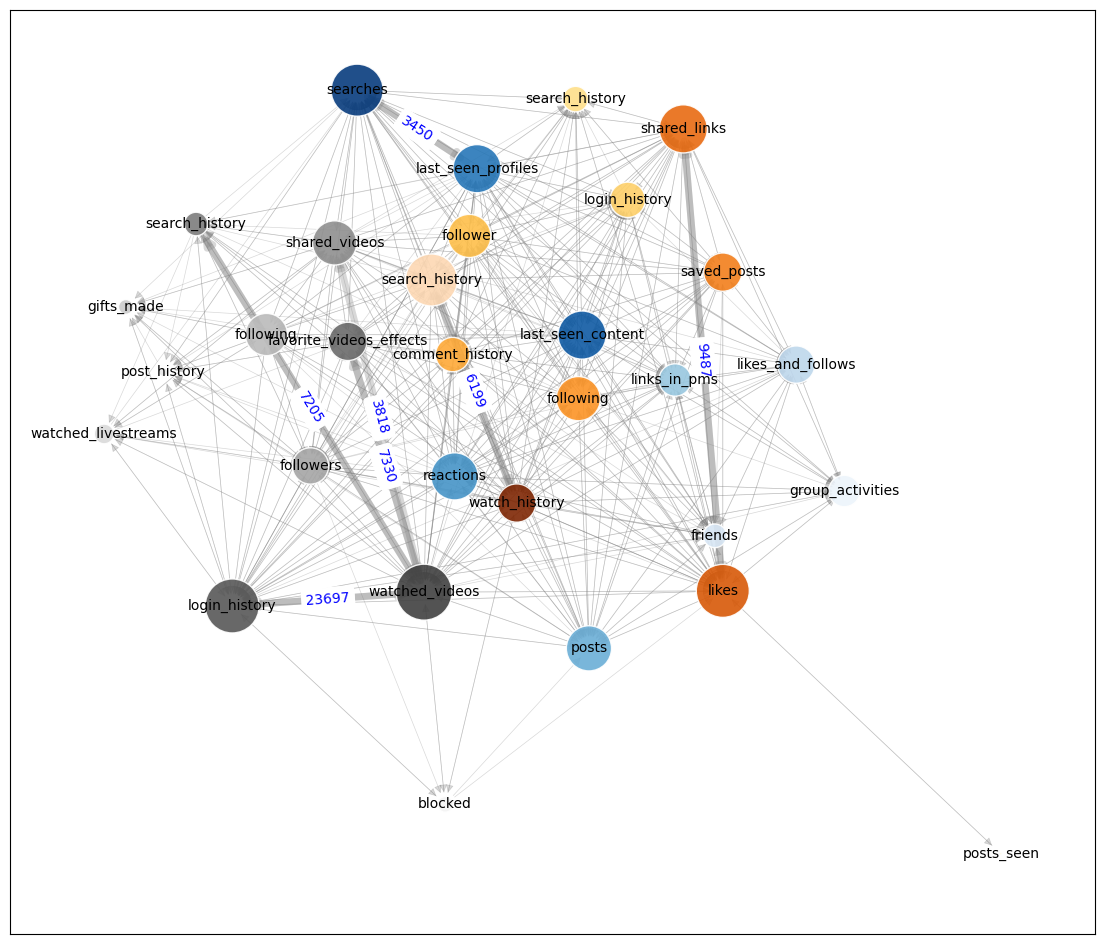

In [ ]:
from colormap import rgb2hex
plt.figure(figsize=(14,12))
platform = ['facebook', 'youtube','tiktok', 'instagram']
colormap = {'instagram': "YlOrBr", 'facebook': "Blues", 'tiktok': "Greys", "youtube": "Oranges"}
weights = [G[u][v]['weight'] for u,v in G.edges()]
values = [G.nodes[node]['platform'] for node,j in G.nodes(data=True)]
for p in platform:
    df_1=data[data.platform==p]
    a_list=df_1.groupby("activity_type").size().reset_index().sort_values([0], ascending=False).activity_type.to_list()
    cmap = plt.get_cmap(colormap[p])
    colors = cmap(np.linspace(0.05, 0.95, len(a_list)))[::-1]*255
    # Reversing color order
    if p=="youtube":
        colors=cmap(np.linspace(0.2, 1, len(a_list)))[::-1]*255
    if p=="instagram":
        colors = cmap(np.linspace(0.2, 0.7, len(a_list)))[::-1]*255
    if p=="tiktok":
        colors = cmap(np.linspace(0.1, 0.8, len(a_list)))[::-1]*255
    node_color=[rgb2hex(int(i[0]), int(i[1]), int(i[2])) for i in colors]
    nx.draw_networkx_nodes(a_list,pos, node_size=[v**2/2 for i,v in dict(G.degree()).items() if i in a_list], node_color=node_color, edgecolors="white", alpha=0.9)
nx.draw_networkx_edges(G,pos, width=list(edges_width.values()),edge_color= "gray", alpha=0.3, arrowsize=12)
nx.draw_networkx_edge_labels(
    G, pos,
    edge_labels=edges_dict,
    font_color='blue'
)
nx.draw_networkx_labels(G, pos, labels={node: "_".join(node.split("_")[1:4]) for node in G.nodes()}, font_size=10, font_color='black')

plt.savefig('../network2.png', dpi=300, bbox_inches='tight')
plt.show()
